In [33]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
from plot_function import *
from itertools import cycle
from pathlib import Path
from datetime import date

In [34]:
connection = sqlite3.connect('./sample_database.db')
c = connection.cursor()

# Extract data from database

In [35]:
TC_fit = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
HB_fit = pd.read_sql_query("""SELECT * FROM hb_fit_results""", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)

In [37]:
HB_fit.head()

,sample_ID,temperature,yield_stress_HB,err_yield_stress_HB,K,err_K,n,err_n,AIC
0,20210716001,20,0.373407,0.011315,13.225142,0.156590,0.579168,0.003600,-575.798239
1,20210716006,20,9.300611,0.125074,26.481206,0.452363,0.539478,0.004281,-415.818729
2,20210716008,20,69.933281,0.772715,96.071475,1.883946,0.486033,0.004550,-437.407426
3,20210716006,50,9.126988,0.061589,12.328694,0.134187,0.531477,0.002428,-457.453918
4,20210907006,20,25.997643,0.259329,49.849989,0.761706,0.527476,0.003509,-556.248754


# Plot the concentration sweep

In [20]:
flow_curves = pd.merge(left=flow_curves, right=dilu, how='left', on=['sample_ID'])
flow_curves_concentration_sweep = flow_curves[flow_curves.dilution_serie == 'carbopol~974p~in~propylenglycol']


In [21]:
np.sort(flow_curves_concentration_sweep.w_percent.unique())

array([1.3 , 1.5 , 1.7 , 1.75, 1.78, 1.8 , 1.85, 1.9 , 2.  , 2.7 , 3.  ])

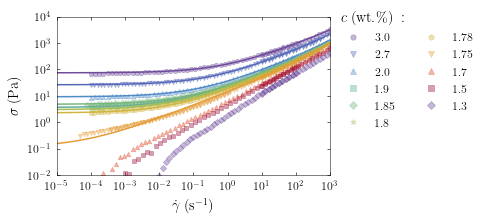

In [22]:
fig, ax, color, marker = create_plot()
# select 20°C
df20 = flow_curves_concentration_sweep[flow_curves_concentration_sweep.temperature == 20]
df20 = df20.sort_values('w_percent', ascending=False)
x = np.logspace(-5, 3, 30)
for c, dfh in df20.groupby('w_percent', sort=False):
    col = next(color)
    TC = TC_fit[(TC_fit.sample_ID == list(dfh.sample_ID)[0]) & (TC_fit.temperature == 20)]
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$')
    if len(TC > 0):
        ax.loglog(x, 
                  np.array(TC.yield_stress_TC)+ np.array(TC.viscinf) * x + 
                  np.array(TC.yield_stress_TC) * (x / float(TC.caract_shear_rate))**0.5 ,
                  c=col, ls='-', marker='', lw=1.5)
    
ax.legend(title='$c~(\mathrm{wt.}\%)~:$', bbox_to_anchor=(1, 1.1), ncol=2)._legend_box.align='left'
ax.set(xlim=(1e-5, 1e3), ylim=(1e-2, 1e4))
ax.set(xlabel='$\dot{\gamma}~(\mathrm{s}^{-1})$', 
       ylabel='$\sigma~\mathrm{(Pa)}$', 
      xticks=[1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000], 
      yticks=[0.01, 0.1, 1, 10, 100, 1000, 10000])
fig.savefig('./figures/concentration_sweep.svg')

# TC Parameters for concentration sweep

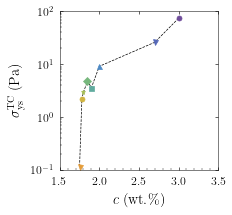

In [23]:
TC_fit_merge = pd.merge(left=TC_fit, right=dilu, how='left', on=['sample_ID'])

TC_dilu = TC_fit_merge[(TC_fit_merge.dilution_serie == 'carbopol~974p~in~propylenglycol') & (TC_fit_merge.temperature == 20)]
TC_dilu = TC_dilu.sort_values('w_percent', ascending=False)

fig, ax, color, marker = create_plot(two_sided=True)

ax.plot(TC_dilu.w_percent, TC_dilu.yield_stress_TC, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.yield_stress_TC, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(0.1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys}^\mathrm{TC}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures/concentration_sweep_parameters/ys.svg')

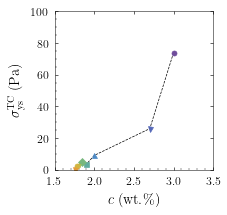

In [46]:
TC_fit_merge = pd.merge(left=TC_fit, right=dilu, how='left', on=['sample_ID'])

TC_dilu = TC_fit_merge[(TC_fit_merge.dilution_serie == 'carbopol~974p~in~propylenglycol') & (TC_fit_merge.temperature == 20)]
TC_dilu = TC_dilu.sort_values('w_percent', ascending=False)

fig, ax, color, marker = create_plot(two_sided=True)

ax.plot(TC_dilu.w_percent, TC_dilu.yield_stress_TC, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.yield_stress_TC, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(0, 100), 
       #yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys}^\mathrm{TC}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures/concentration_sweep_parameters/ys.png', dpi = 300)

In [24]:
TC_dilu

,sample_ID,temperature,yield_stress_TC,err_yield_stress_TC,caract_shear_rate,err_caract_shear_rate,viscinf,err_viscinf,crit_strain_TC,err_crit_strain_TC,AIC,solvent,microgel_type,w_percent,dilution_serie
2,20210716008,20,73.968630,76.037272,0.758362,0.045615,0.398315,0.061344,0.004084,0.005072,0.098983,propylenglycol,carbopol~974p,3.00,carbopol~974p~in~propylenglycol
4,20210907006,20,26.012211,0.280136,0.278778,0.018522,0.600169,0.033926,0.006432,0.000860,-49.462675,propylenglycol,carbopol~974p,2.70,carbopol~974p~in~propylenglycol
1,20210716006,20,9.124571,27.725465,0.119434,0.004493,0.468318,0.008372,0.006130,0.018966,-202.542344,propylenglycol,carbopol~974p,2.00,carbopol~974p~in~propylenglycol
27,20210716005,20,3.604169,0.119607,0.032318,0.001090,0.475512,0.004545,0.004264,0.000326,-282.145086,propylenglycol,carbopol~974p,1.90,carbopol~974p~in~propylenglycol
6,20210907005,20,4.746656,20.326391,0.057685,0.001599,0.456668,0.006872,0.005550,0.024003,-288.315233,propylenglycol,carbopol~974p,1.85,carbopol~974p~in~propylenglycol
13,20210716004,20,2.966881,0.176691,0.026528,0.000934,0.512447,0.006528,0.004582,0.000493,-283.644984,propylenglycol,carbopol~974p,1.80,carbopol~974p~in~propylenglycol
5,20210907004,20,2.238038,16.598882,0.021492,0.000590,0.450764,0.004034,0.004329,0.032263,-340.996907,propylenglycol,carbopol~974p,1.78,carbopol~974p~in~propylenglycol
0,20210716001,20,0.110776,0.066782,0.000066,0.000063,0.542145,0.010965,0.000323,0.000507,-209.961290,propylenglycol,carbopol~974p,1.75,carbopol~974p~in~propylenglycol


In [26]:
TC_dilu.loc[:, ['w_percent', 'viscinf', 'caract_shear_rate', 'yield_stress_TC', 'AIC']]

,w_percent,viscinf,caract_shear_rate,yield_stress_TC,AIC
2,3.00,0.398315,0.758362,73.968630,0.098983
4,2.70,0.600169,0.278778,26.012211,-49.462675
1,2.00,0.468318,0.119434,9.124571,-202.542344
27,1.90,0.475512,0.032318,3.604169,-282.145086
6,1.85,0.456668,0.057685,4.746656,-288.315233
13,1.80,0.512447,0.026528,2.966881,-283.644984
5,1.78,0.450764,0.021492,2.238038,-340.996907
0,1.75,0.542145,0.000066,0.110776,-209.961290


In [38]:
HB_fit_merge = pd.merge(left=HB_fit, right=dilu, how='left', on=['sample_ID'])

HB_dilu = HB_fit_merge[(HB_fit_merge.dilution_serie == 'carbopol~974p~in~propylenglycol') & (HB_fit_merge.temperature == 20)]
HB_dilu = HB_dilu.sort_values('w_percent', ascending=False)

In [39]:
HB_dilu.loc[:, ['w_percent', 'K', 'n', 'yield_stress_HB', 'AIC']]

,w_percent,K,n,yield_stress_HB,AIC
2,3.00,96.071475,0.486033,69.933281,-437.407426
4,2.70,49.849989,0.527476,25.997643,-556.248754
1,2.00,26.481206,0.539478,9.300611,-415.818729
27,1.90,19.484677,0.560191,3.994301,-408.602547
6,1.85,20.709460,0.534330,4.795529,-419.814654
13,1.80,18.421148,0.551376,3.201410,-378.654697
5,1.78,15.763149,0.548393,2.382766,-399.781862
0,1.75,13.225142,0.579168,0.373407,-575.798239


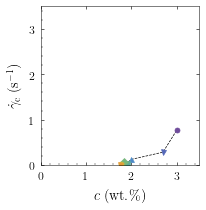

In [ ]:

fig, ax, color, marker = create_plot(two_sided=True)
ax.plot(TC_dilu.w_percent, TC_dilu.caract_shear_rate, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.caract_shear_rate, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(1e-5, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures/concentration_sweep_parameters/gammadotcrit.svg')

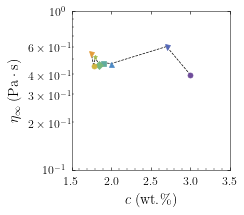

In [61]:

fig, ax, color, marker = create_plot(two_sided=True)
ax.plot(TC_dilu.w_percent, TC_dilu.viscinf, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.viscinf, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(0.1, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\eta_\infty~\mathrm{(Pa \cdot s)}$'
      )

fig.savefig('./figures/concentration_sweep_parameters/viscinf.svg')

# Effect of temperature 

## on both critical strains

In [111]:
df = pd.merge(left=sample, right=amp_sweeps, on=['sample_ID', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=dilu, on=['sample_ID'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=solvents, on=['solvent', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df.tail()

,sample_ID,temperature,yield_stress_TC,err_yield_stress_TC,caract_shear_rate,err_caract_shear_rate,viscinf,err_viscinf,crit_strain_TC,err_crit_strain_TC,crit_strain_intersect,crit_strain_10percent,solvent,microgel_type,w_percent,dilution_serie,solvent_viscosity
29,20210716005,30,3.340430,0.101961,0.054017,0.001942,0.275546,0.003916,0.004456,0.000360,0.084116,0.017006,propylenglycol,carbopol~974p,1.9,carbopol~974p~in~propylenglycol,0.02529
30,20210716005,35,3.226469,0.144022,0.067334,0.002483,0.217420,0.003655,0.004537,0.000446,0.086762,0.017006,propylenglycol,carbopol~974p,1.9,carbopol~974p~in~propylenglycol,0.01607
31,20210716005,40,3.170269,0.088356,0.086056,0.003153,0.177509,0.003342,0.004818,0.000402,0.089411,0.017006,propylenglycol,carbopol~974p,1.9,carbopol~974p~in~propylenglycol,0.01150
32,20210716005,45,3.301242,0.188417,0.114974,0.004279,0.147886,0.003122,0.005151,0.000594,0.091722,0.013293,propylenglycol,carbopol~974p,1.9,carbopol~974p~in~propylenglycol,0.01032
33,20210716005,50,3.277103,0.163287,0.141747,0.004967,0.124429,0.002886,0.005382,0.000582,0.098349,0.013293,propylenglycol,carbopol~974p,1.9,carbopol~974p~in~propylenglycol,0.01130


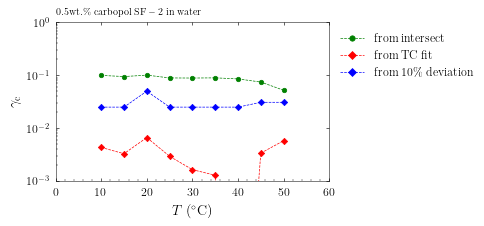

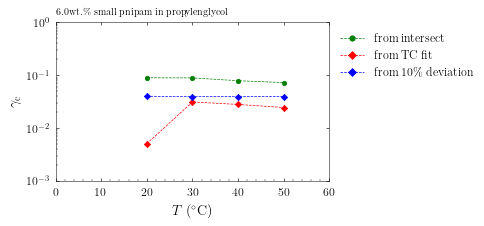

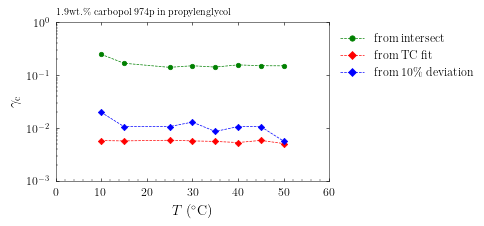

In [6]:
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        fig, ax, _, _ = create_plot()
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_intersect,
                ls='--', marker='o', c='g', mfc='g', label='$\mathrm{from~intersect}$')
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_TC, ls='--', marker='D', c='r', mfc='r', label='$\mathrm{from~TC~fit}$')
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_10percent, ls='--', marker='D', c='b', mfc='b', label='$\mathrm{from~10\%~deviation}$')

        ax.legend(bbox_to_anchor=(1,1))        
        ax.annotate(f'${concentration}\mathrm{{wt.}}\% \mathrm{{~{microgel}~in~{solvent}}}$', (0, 1.05), xycoords="axes fraction")  
        ax.set(yscale='log',
               xlabel=r'$T~(^\circ \mathrm{C})$',
               ylabel=r'$\gamma_\mathrm{c}$',
               xlim=(0, 60), ylim=(1e-3, 1)
                )
        #
        # fig.savefig(f'cri_strains_temperature_{solvent}_{microgel}.png', bbox_inches='tight', dpi=200)
        plt.show()
        plt.close()

## on yield stress

20210907006
20210716004
20210716005


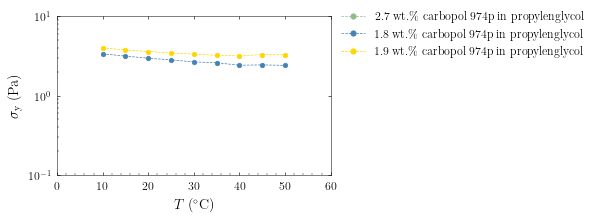

In [41]:
fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        print(sample_ID)
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.yield_stress_TC,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\sigma_\mathrm{y}~\mathrm{(Pa)}$',
       xlim=(0, 60), ylim=(1e-1, 10)
       )
#fig.savefig(f'yield_stress_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

## on viscosities

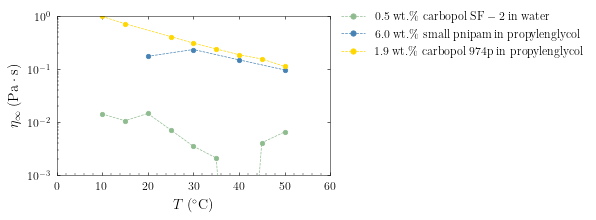

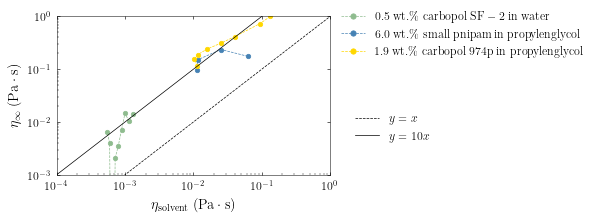

In [8]:
#----------------
# En fonction de la temperature
#----------------

fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.viscinf,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\eta_\infty~\mathrm{(Pa \cdot s)}$',
       xlim=(0, 60), ylim=(1e-3, 1)
       )
#fig.savefig(f'eta_infinity_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

#----------------
# En fonction de la viscosité du solvant
#----------------

fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.solvent_viscosity, unq_sample.viscinf,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
        
x=np.logspace(-4, 0, 10)
ax.plot(x, x, ls='--', c='k', marker='')
ax.plot(x, 10*x, ls='-', c='k', marker='')
handles = [mpl.lines.Line2D([], [], marker='', c='k', ls='--', label=f'$y=x$'),
           mpl.lines.Line2D([], [], marker='', c='k', ls='-', label=f'$y=10x$')]
legend = fig.legend(handles=handles, bbox_to_anchor=(1, 0.5))



ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xscale='log',
       xlabel=r'$\eta_\mathrm{solvent}~(\mathrm{Pa \cdot s})$',
       ylabel=r'$\eta_\infty~\mathrm{(Pa \cdot s)}$',
       xlim=(1e-4, 1), ylim=(1e-3, 1)
       )
#fig.savefig(f'eta_infinity_eta_solvent.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

## on caracteristic shear rates

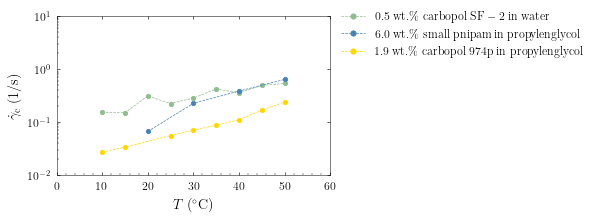

In [9]:
fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.caract_shear_rate,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\dot{\gamma}_\mathrm{c}~\mathrm{(1/s)}$',
       xlim=(0, 60), ylim=(1e-2, 10)
       )
#fig.savefig(f'gammadotc_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

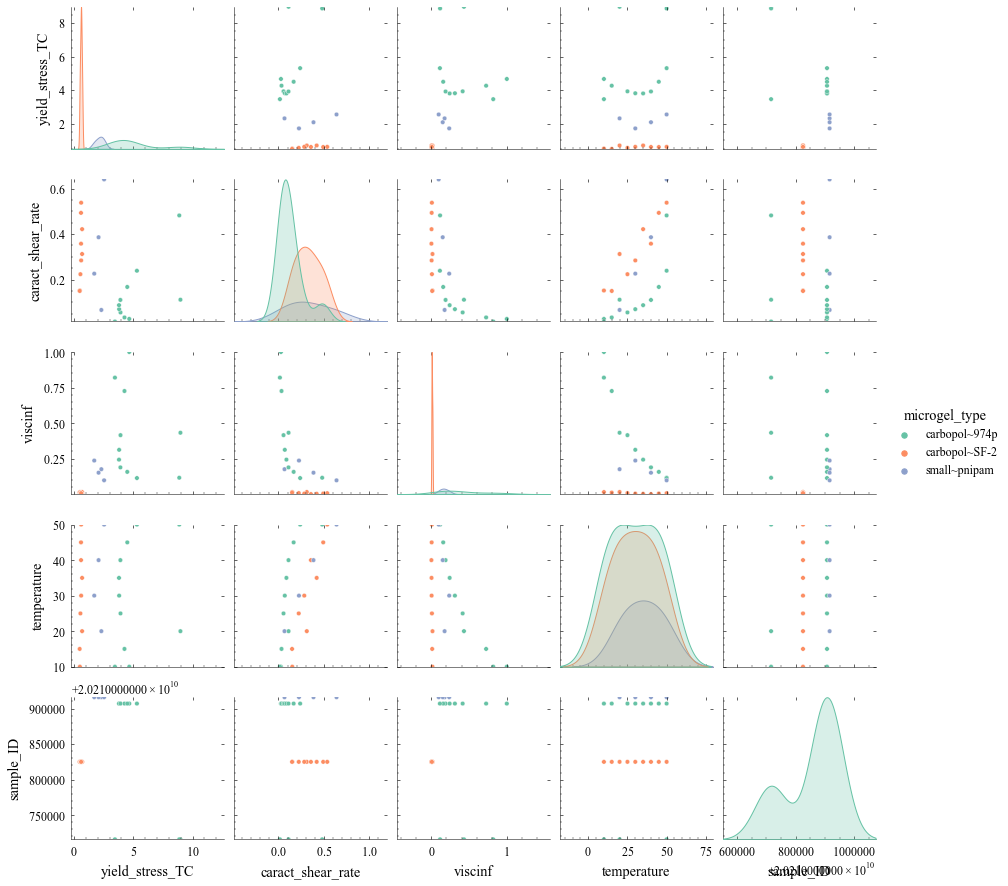

In [10]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)

test = df.loc[:, ['yield_stress_TC', 'caract_shear_rate', 'viscinf', 'temperature', 'microgel_type', 'sample_ID']]
for sample_ID in test.sample_ID.unique():
    if len(test[test.sample_ID == sample_ID]) <= 1:
        test = test[test.sample_ID != sample_ID]


sns.pairplot(test.loc[:, ['yield_stress_TC', 'caract_shear_rate', 'viscinf', 'temperature', 'microgel_type', 'sample_ID']], hue="microgel_type", palette="Set2")
#plt.savefig('test.png', dpi=200)

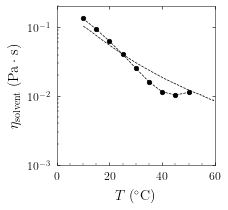

In [15]:
PG = solvents.query("solvent == 'propylenglycol'")
PG = PG.sort_values('temperature')
fig, ax, _, _ = create_plot(two_sided=True)
ax.plot(PG.temperature, PG.solvent_viscosity, c='k', ls='--', mfc='k')
ax.plot(marco_visc.temperature, marco_visc.viscosity, c='k', ls='--', mfc='k', marker='')
ax.set(xlim=(0, 60), ylim=(0.001, 0.2), yscale='log', 
       xlabel='$T~(^\circ \mathrm{C})$', ylabel='$\eta_\mathrm{solvent}~\mathrm{(Pa \cdot s)}$')
fig.savefig('solvent_visc.svg', bbox_inches = 'tight')

In [24]:
marco_visc = pd.read_csv('visc_pg_from_Marco.txt', sep='\t')

marco_visc['round_temperature'] = round(marco_visc.temperature)

visc_round = marco_visc.groupby('round_temperature')['viscosity'].mean()

10.0
0.10205033333333334
15.0
0.07533733333333333
20.0
0.05479937142857143
25.0
0.04025268333333334
30.0
0.0305657
35.0
0.023787283333333336
40.0
0.01861688
45.0
0.0150264
50.0
0.01225682857142857


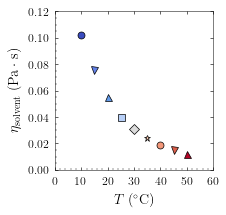

In [39]:
fig, ax, _, marker = create_plot(two_sided=True)
dict_colors = {10: '#3a4cbf', 15: '#6281e9', 20: '#629ae9',
               25: '#b7cff7', 30:'#dbdbdb', 35: '#f3c3ab', 
               40: '#f39779', 45: '#db5e4a', 50: '#b30426'
                }
for T in np.linspace(10, 50, 9):
    print(T)
    print(visc_round[T])
    ax.plot(T, visc_round[T], c='k', ls='--', mfc=dict_colors[T], marker=next(marker), ms=7)
ax.set(xlim=(0, 60), ylim=(0, 0.12), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ \mathrm{C})$', ylabel='$\eta_\mathrm{solvent}~\mathrm{(Pa \cdot s)}$')
fig.savefig('solvent_visc.svg', bbox_inches = 'tight')

In [30]:
visc_round[T]

0.01225682857142857

# Single sample 1.9%

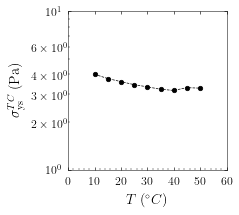

In [55]:
unq_sample = df[df.sample_ID == 20210716005]

fig, ax, _, _ = create_plot(two_sided=True)

ax.plot(unq_sample.temperature, unq_sample.yield_stress_TC,  c='k', ls='--', mfc='k')

ax.set(ylim=(1, 10), xlim=(0.60), 
       yscale='log',
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ C)$', 
       ylabel='$\sigma_\mathrm{ys}^{TC}~(\mathrm{Pa})$'
      )
fig.savefig('ys.svg')

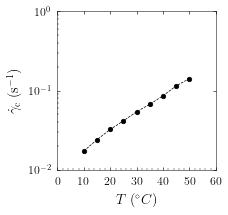

In [64]:
unq_sample = df[df.sample_ID == 20210716005]

fig, ax, _, _ = create_plot(two_sided=True)


ax.plot(unq_sample.temperature, unq_sample.caract_shear_rate,  c='k', ls='--', mfc='k')

ax.set(ylim=(0.01, 1), 
       yscale='log',
       xlim=(0, 60), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ C)$', 
       ylabel='$\dot{\gamma}_\mathrm{c}~(\mathrm{s}^{-1})$'
      )
fig.savefig('caract.svg')

In [50]:
unq_sample.keys()

Index(['sample_ID', 'temperature', 'yield_stress_TC', 'err_yield_stress_TC',
       'caract_shear_rate', 'err_caract_shear_rate', 'viscinf', 'err_viscinf',
       'crit_strain_TC', 'err_crit_strain_TC', 'crit_strain_intersect',
       'crit_strain_10percent', 'solvent', 'microgel_type', 'w_percent',
       'dilution_serie', 'solvent_viscosity'],
      dtype='object')

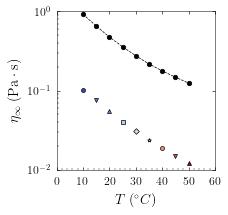

In [62]:
unq_sample = df[df.sample_ID == 20210716005]

fig, ax, _, marker = create_plot(two_sided=True)


ax.plot(unq_sample.temperature, unq_sample.viscinf,  c='k', ls='--', mfc='k')

for T in np.linspace(10, 50, 9):
    ax.plot(T, visc_round[T], c='k', ls='--', mfc=dict_colors[T], marker=next(marker), ms=4)

ax.set(ylim=(0.01, 1), 
       yscale='log',
       xlim=(0, 60), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ C)$', 
       ylabel='$\eta_\infty~(\mathrm{Pa \cdot s})$'
      )
fig.savefig('visc.svg')